In [26]:
from dataclasses import dataclass
from typing import Tuple, Dict,Mapping, Iterator
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.markov_decision_process import FinitePolicy, StateActionMapping
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical, Constant
from scipy.stats import poisson
from rl.dynamic_programming import value_iteration_result,value_iteration,almost_equal_vfs
from rl.iterate import converged, iterate,converge
import math

##Define the stateclass
@dataclass(frozen=True)
class FrogState:
    pos: int

# 0 is A,1 is B
FrogStateMapping = StateActionMapping[FrogState, int]


class SimpleFrogMDP(FiniteMarkovDecisionProcess[FrogState, int]):

    def __init__(
        self,
        n:int
    ):
        self.n:int=n
        super().__init__(self.get_action_transition_reward_map())
    def get_action_transition_reward_map(self) -> FrogStateMapping:
        d: Dict[FrogState, Dict[int, Categorical[Tuple[FrogState,float]]]] = {}
        d[FrogState(0)]=None
        d[FrogState(self.n)]=None
        for i in range(1,self.n):
            d1:Dict[int,Categorical[Tuple[FrogState,float]]]={}
            for action in range(2):
                sr_probs_dict:Dict[Tuple[FrogState,float]]={}
                if(action==0):
                    if(i==self.n-1):
                        sr_probs_dict[(FrogState(self.n+1),1.0)]=(self.n-i)/self.n
                    else:
                        sr_probs_dict[(FrogState(self.n+1),0.0)]=(self.n-i)/self.n
                    sr_probs_dict[(FrogState(self.n-1),0.0)]=i/self.n
                if(action==1):
                        for j in range(0,self.n):
                            if(j!=i):
                                sr_probs_dict[(FrogState(j),0.0)]=1/self.n
                        sr_probs_dict[(FrogState(self.n),1.0)]=1/self.n
                d1[action]=Categorical(sr_probs_dict)
            d[FrogState(i)]=d1
        return d
user_gamma=1.0


In [27]:
import matplotlib.pyplot as plt

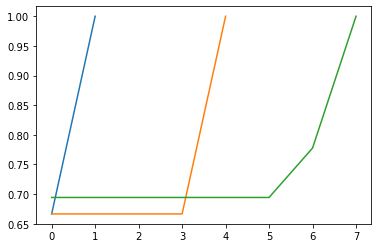

In [28]:
for i in [3,6,9]:
    si_mdp1: FiniteMarkovDecisionProcess[FrogState, int] =SimpleFrogMDP(n=i)
    si_mdp1
    opt_vf_vi, opt_policy_vi = value_iteration_result(si_mdp1, gamma=user_gamma)
    plt.plot(list(opt_vf_vi.values()))

dict_values([0.6999407857834122, 0.6999407857834122, 0.6999407857834122, 0.6999407857834122, 0.6999407857834122, 0.6999407857834122, 0.6999407857834122, 0.7999164034589347, 0.9999059538913014])